coefficient= [ 1.01269855e+00 -1.19080333e-03 -1.98018585e+03  2.30632194e-01]
intercept= -11.613248882223331
R²= 0.9888660522620746
-----NEXT-----
2192


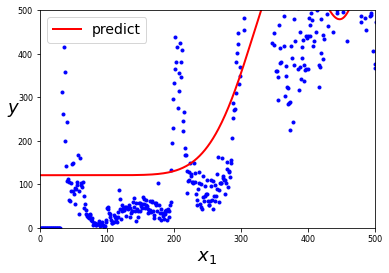

,x1,x2,x3,x4,y
0,0.000000,1,0.000000,1,0.0
1,0.000000,1,0.000000,2,2.0
2,0.000000,4,0.000000,3,13.0
3,0.000000,0,0.000000,4,-15.0
4,0.000000,0,0.000000,5,19.0
...,...,...,...,...,...
539,1510.440111,166272,0.035775,540,1629.0
540,1520.482959,167314,0.538796,541,1486.0
541,1569.151082,168448,0.040236,542,1318.0
542,2757.396058,169442,0.049009,543,1365.0


In [ ]:
import sys
import requests
import logging
import pandas as pd
from time import sleep
import os
import numpy as np
import re

from datetime import datetime
import datetime

from bs4 import BeautifulSoup
from google.colab import drive

import xml.etree.ElementTree as elemTree
import xml.etree.ElementTree as ET

from urllib.request import Request
import urllib.request
from urllib.request import urlopen
from urllib.parse import urlencode
from urllib.parse import quote
from urllib.parse import quote_plus
from urllib import request
from flask import request

import plotly.offline as py
import plotly.graph_objs as go
import matplotlib.ticker as ticker
import matplotlib.ticker as mticker
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# Hide INFO Level Log 
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# Get Total Data in list from Data.go.kr
now_dt = int(datetime.datetime.now().strftime('%H%M%S'))
if now_dt > 4000:
  end_create_dt = int(str(datetime.datetime.now().date()).replace('-',''))
else:
  end_create_dt = int(str(datetime.datetime.now().date()).replace('-','')) - 1

url = 'http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19InfStateJson'
queryParams = '?' + urlencode({ quote_plus('ServiceKey') : 'cwrcT5TevRi39dJ3+8FTHHLLQyxGCWKNdMYBYqAwwrCHqPAK/1ZHilEhfJ31syfsZ1BOVUiLL4DIjRLU+Hfg2w==', quote_plus('startCreateDt') : '20200122', quote_plus('endCreateDt') : '%d' % (end_create_dt) })
request = Request(str(url) + queryParams)
request.get_method = lambda: 'GET'
response_body = urlopen(request).read().decode('ascii')

root = ET.fromstring(response_body)
root = root.findall('.//item')

dp_recovered_cnt = []
dp_acc_exam_cnt = []
dp_date = []
dp_decide_cnt = []
dp_result_neg_cnt = []
dp_acc_exam_comp_cnt = []

index = 0
for i in root:
  # S : Susceptible = S + E + I + R = N
  # E : Exposed = Exam Count * β + Gaussian Random Variable (Add Noise)
  # I : Infectious
  # R : Recovered = Death + Clear
  # β : Transmission Rate = 1 - (Result Negative Count / Exam Complete Count)
  # t : date
  dp_result_neg_cnt.append(i.findtext(".//resutlNegCnt"))
  dp_acc_exam_comp_cnt.append(i.findtext(".//accExamCompCnt"))
  dp_recovered_cnt.append(int(i.findtext(".//deathCnt")) + int(i.findtext(".//clearCnt")))
  dp_decide_cnt.append(int(i.findtext(".//decideCnt")))
  dp_acc_exam_cnt.append(i.findtext(".//accExamCnt"))
  dp_date.append(len(root) - index)
  index = index + 1

for i, j in enumerate(dp_acc_exam_comp_cnt):
  if j is None:
    dp_acc_exam_comp_cnt[i] = 0
    dp_result_neg_cnt[i] = 0
    dp_acc_exam_cnt[i] = 0
  if j == '':
    dp_acc_exam_comp_cnt[i] = 0
    dp_result_neg_cnt[i] = 0
    dp_acc_exam_cnt[i] = 0

dp_recovered_cnt.reverse()
dp_acc_exam_cnt.reverse()
dp_date.reverse()
dp_decide_cnt.reverse()
dp_acc_exam_comp_cnt.reverse()
dp_result_neg_cnt.reverse()

# Get S(t), E(t), I(t), R(t), t, β
n = 51710000
s_t = []
e_t = []
i_t = []
r_t = []
t = []
beta = []

index = 0
for i in root:
  if index + 1 < len(root):
    # R(t)
    r_t.append(dp_recovered_cnt[index])
    # E(t)
    if (int(dp_acc_exam_comp_cnt[index + 1]) - int(dp_acc_exam_comp_cnt[index])) != 0:
      e_t.append(float((float(dp_acc_exam_cnt[index + 1]) - float(dp_acc_exam_cnt[index])) * (1 - ((float(dp_result_neg_cnt[index + 1]) - float(dp_result_neg_cnt[index])) / (float(dp_acc_exam_comp_cnt[index + 1]) - float(dp_acc_exam_comp_cnt[index]))))))
    else:
      e_t.append(0)
    # β
    if (int(dp_acc_exam_comp_cnt[index + 1]) - int(dp_acc_exam_comp_cnt[index])) != 0:
      beta.append((1 - ((float(dp_result_neg_cnt[index + 1]) - float(dp_result_neg_cnt[index])) / (float(dp_acc_exam_comp_cnt[index + 1]) - float(dp_acc_exam_comp_cnt[index])))))
    else:
      beta.append(0)
    # I(t)
    i_t.append(float(dp_decide_cnt[index + 1]) - float(dp_decide_cnt[index]))
    # s_t
    s_t.append(n - e_t[index] - i_t[index] - r_t[index])
    # t
    t.append(dp_date[index])
  index = index + 1

# Get Live Data from Web
url = 'https://corona-live.com/v1/domestic/'
res = requests.get(url, headers={"User-Agent":"Mozilla/5.0"})
res.raise_for_status()
s = BeautifulSoup(res.text, "lxml")
today = s.find('#__next > div.gnb')

# Get Total Data in Data Frame from CSV
url = 'https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv'
data = pd.read_csv(url, error_bad_lines = False)
data.head()
df_total = data[data['Country/Region'] == 'Korea, South']
df_total = np.column_stack([df_total.Date, df_total.Confirmed, df_total.Recovered, df_total.Deaths])
df_total = pd.DataFrame(df_total)
df_total = df_total.reset_index().rename(columns={0: 'date', 1: 'confirmed', 2: 'recovered', 3: 'deaths'})
df_total = df_total.drop("index", axis=1)

# Set Daily Data in List
dateDiffList = []
confirmedDiffList = []
recoveredDiffList = []
deathsDiffList = []

index = 0
for i in df_total.date:
  if index + 1 < len(df_total):
    dateDiffList.append(index)
    confirmedDiffList.append(int(df_total.iloc[index + 1]['confirmed']) - int(df_total.iloc[index]['confirmed']))
    recoveredDiffList.append(int(df_total.iloc[index + 1]['recovered']) - int(df_total.iloc[index]['recovered']))
    deathsDiffList.append(int(df_total.iloc[index + 1]['deaths']) - int(df_total.iloc[index]['deaths']))
    index = index + 1

# Add First Data
dateDiffList.insert(0, 0)
confirmedDiffList.insert(0, 0)
recoveredDiffList.insert(0, 0)
deathsDiffList.insert(0, 0)

df_dp_total = pd.DataFrame({
'x1' : e_t,
'x2' : r_t,
'x3' : beta,
'x4' : t,
'y' : i_t
})

X = df_dp_total[['x1', 'x2', 'x3', 'x4']]
Y = df_dp_total['y']
reg = LinearRegression().fit(X, Y)
# Weights
print("coefficient=", reg.coef_)
# Bias
print("intercept=", reg.intercept_)
# Coefficient of determination
print("R²=", reg.score(X, Y))

print("-----NEXT-----")

print(round(reg.coef_[0] * ((float(df_dp_total.x1.loc[len(df_dp_total) - 1]) * 2) - float(df_dp_total.x1.loc[len(df_dp_total) - 2])) + 
reg.coef_[1] * ((float(df_dp_total.x2.loc[len(df_dp_total) - 1]) * 2) - float(df_dp_total.x2.loc[len(df_dp_total) - 2])) + 
reg.coef_[2] * ((float(df_dp_total.x3.loc[len(df_dp_total) - 1]) * 2) - float(df_dp_total.x3.loc[len(df_dp_total) - 2])) + 
reg.coef_[3] * ((float(df_dp_total.x4.loc[len(df_dp_total) - 1]) * 2) - float(df_dp_total.x4.loc[len(df_dp_total) - 2])) + 
reg.intercept_))

# Get E(max(t+1))
poly_list = []
poly = PolynomialFeatures(degree=16)

X = np.array(t).reshape(-1, 1)
Y = np.array(e_t)
X_poly = poly.fit_transform(X)

lin_reg = LinearRegression()
lin_reg.fit(X_poly, Y)
lin_reg.intercept_, lin_reg.coef_

X_new=np.linspace(0, len(t), len(t)).reshape(-1, 1)
X_new_poly = poly.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, Y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="predict")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 500, 0, 500])
plt.show()

poly.fit_transform(X)

df_dp_total

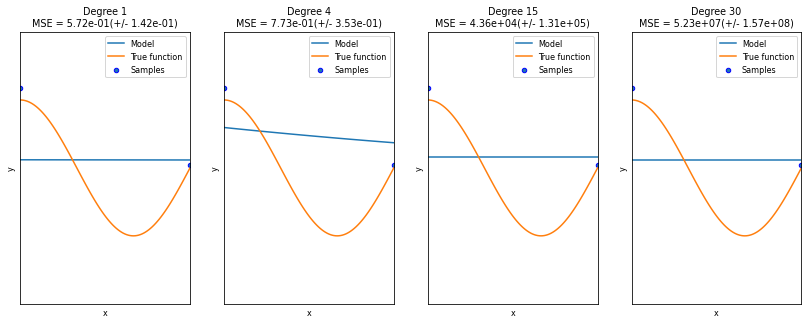

In [ ]:
#print(__doc__)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import random

def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15, 30]

X = np.arange(30)
y = true_fun(X) + np.random.randn(30) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()

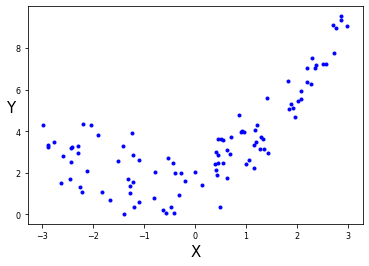

[-1.82050583]
[-1.82050583  3.31424148]


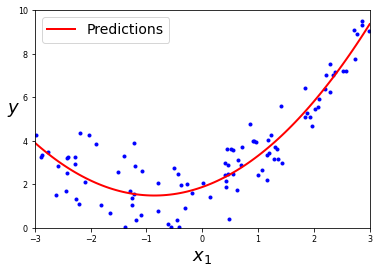

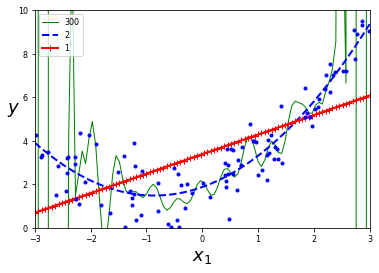

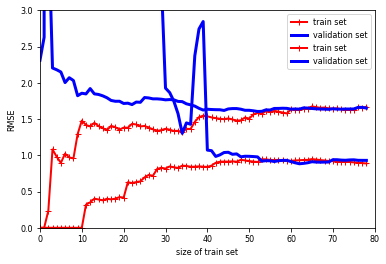

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

m = 100
X = 6 * np.random.rand(m,1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)  # 약간의 노이즈 포함

plt.plot(X,y,"b.")
plt.ylabel("Y", fontsize=15,rotation=0)
plt.xlabel("X", fontsize=15)
plt.show()

from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

print(X[0])
print(X_poly[0])

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_ , lin_reg.coef_

X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range (1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth = 2, label = "train set")
    plt.plot(np.sqrt(val_errors), "b-", linewidth = 3, label = "validation set") 
    plt.xlabel("size of train set")
    plt.ylabel("RMSE")
    plt.legend()

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias = False)),
    ("lin_reg", LinearRegression())
])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0,80,0,3])
plt.show()